# XGBoost (Regresión)

Además de las operaciones básicas de limpieza de datos, existen algunos requisitos para que XGBoost logre el máximo rendimiento. Principalmente:

* Las características numéricas deben escalarse
* Las características categóricas deben codificarse

En primer lugar, al igual que con cualquier otro conjunto de datos, importaremos el conjunto de datos. En este caso es el de Vivienda de Boston y lo almacenaremos en una variable llamada boston.

Importamos las librerías que vamos a utilizar

In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn import tree, datasets, metrics
#from sklearn import neighbors, datasets, metrics
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

Vamos a ignorar los warnings que no son importantes para lo que vamos a hacer. **Nota** En caso de no tener instalado XGBoost descomente y ejecuta  la línea de comando de instalación.

In [2]:
import warnings
warnings.filterwarnings('ignore')

#pip install xgboost

## Entendimiento de los datos

Cargamos los datos para entenderlos

In [3]:
print(housing.data.shape)
print(housing.DESCR)

(20640, 8)
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset 

In [4]:
data = pd.DataFrame(housing.data)
data.columns = housing.feature_names

In [5]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Resulta que este conjunto de datos tiene 8 columnas (incluida la variable de destino MedInc) y 20640 filas. Observe que las columnas son de tipo de datos flotantes, lo que indica la presencia de solo entidades continuas sin valores faltantes en ninguna de las columnas. 

In [15]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [16]:
data['median_house_value'] = housing.target

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MedInc              20640 non-null  float64
 1   HouseAge            20640 non-null  float64
 2   AveRooms            20640 non-null  float64
 3   AveBedrms           20640 non-null  float64
 4   Population          20640 non-null  float64
 5   AveOccup            20640 non-null  float64
 6   Latitude            20640 non-null  float64
 7   Longitude           20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Separamos la variable de destino y el resto de las variables usando .iloc para crear subconjuntos de datos.

In [18]:
X, y = data.iloc[:,:-1],data.iloc[:,-1]

Ahora, convertiremos el conjunto de datos en una estructura de datos optimizada llamada Dmatrix compatible con XGBoost y que le brinda su aclamado rendimiento  y ganancia de eficiencia.

In [19]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

Ahora, crearemos el conjunto de entrenamiento y prueba para la validación cruzada de los resultados utilizando la función train_test_split del módulo model_selection de sklearn con un tamaño de test_size igual al 20 % de los datos. Además, para mantener la reproducibilidad de los resultados, también se asigna un estado aleatorio.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

El siguiente paso es instanciar un objeto regresor XGBoost llamando a la clase XGBRegressor() de la biblioteca XGBoost con los hiperparámetros pasados como argumentos. Para problemas de clasificación, se habría utilizado la clase XGBClassifier().

In [21]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

Ajustamos el regresor al conjunto de entrenamiento y hacemos predicciones en el conjunto de prueba utilizando los métodos .fit() y .predict().

In [22]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

Calculamos el rmse invocando la función mean_sqaured_error del módulo de métricas de sklearn.

In [23]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.874880


Crearemos un diccionario de hiperparámetros params que contiene todos los hiperparámetros y sus valores como pares clave-valor, pero excluiremos los n_estimadores del diccionario de hiperparámetros porque usarrmod num_boost_rounds en su lugar.

Utilizaremos estos parámetros para crear un modelo de validación cruzada de 3 modelos, invocando el método cv() de XGBoost y almacenaremos los resultados en un dataframe cv_results. Tenga en cuenta que aquí está utilizando el objeto Dmatrix que creó anteriormente.

In [24]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [25]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.130020,0.005935,1.130636,0.012536
1,1.065704,0.005066,1.067344,0.011502
2,1.044020,0.004735,1.046455,0.011148
3,1.005394,0.004526,1.008630,0.011003
4,0.989036,0.004147,0.992990,0.010926


In [26]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.633226
Name: test-rmse-mean, dtype: float64


Puede ver que su RMSE para la predicción de precios se ha reducido en comparación a la última  y resultó ser de alrededor de 0.217. Puede alcanzar un RMSE aún más bajo para un conjunto diferente de hiperparámetros. Puede considerar aplicar técnicas como **Grid Search, Random Search y Bayesian Optimization para alcanzar el conjunto óptimo de hiperparámetros.**

**Visualización de árboles de XGBoost y la importancia de sus atributos**

Podemos visualizar árboles individuales del modelo totalmente potenciado que crea XGBoost utilizando todo el conjunto de datos de viviendas. XGBoost tiene una función plot_tree() que facilita este tipo de visualización. Una vez que entrena un modelo usando la API de aprendizaje XGBoost, puede pasarlo a la función plot_tree() junto con la cantidad de árboles que desea trazar usando el argumento num_trees.

In [27]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

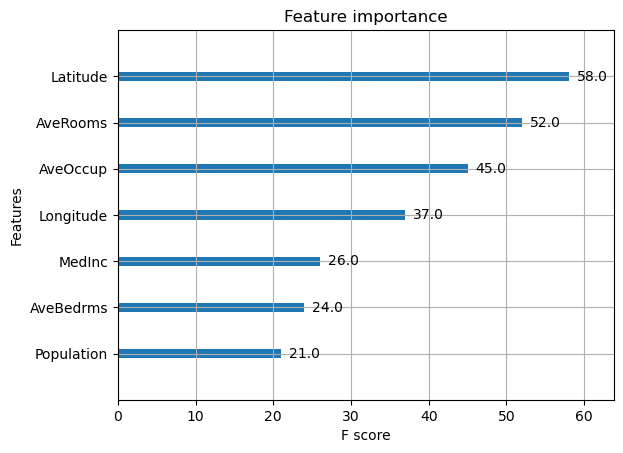

In [28]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# Clasificación a partir de un ensamble extremo: XGBoost

Entrenaremos y construiremos nuestro modelo utilizando un conjunto de datos de clientes de supermercado.

In [29]:
df = pd.read_csv("10-01-ComprasClientes.csv")

In [30]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [31]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [32]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64

No hay valores faltante. Ahora definimos la matriz de atributos y el vector de la variable objetivo.

In [33]:
X = df.drop('Channel', axis=1)

y = df['Channel']

In [34]:
X.head()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,3,12669,9656,7561,214,2674,1338
1,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
3,3,13265,1196,4221,6404,507,1788
4,3,22615,5410,7198,3915,1777,5185


In [35]:
y.head()

0    2
1    2
2    2
3    1
4    2
Name: Channel, dtype: int64

Podemos ver que las etiquetas y contienen valores como 1 y 2. Tendrmos que convertirlos en 0 y 1 para un análisis más detallado. Lo haremos de la siguiente manera

In [36]:
# convert labels into binary values

y[y == 2] = 0

y[y == 1] = 1

In [37]:
y.head()

0    0
1    0
2    0
3    1
4    0
Name: Channel, dtype: int64

Ahora, convertiremos el conjunto de datos en una estructura de datos optimizada llamada Dmatrix que admite XGBoost y le brinda su aclamado rendimiento y ganancias de eficiencia.

In [38]:
# import XGBoost
import xgboost as xgb

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [39]:
xgb_classifier = xgb.XGBClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [40]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Dividimos los datos en conjuntos de prueba y entrenamiento. Luego con estos datos entrenaremos el clasificador XGBoost

In [41]:
# import XGBClassifier
from xgboost import XGBClassifier

# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }
                      
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)

# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Haremos ahora las predicciones con XGBoost y calcularemos su exactitud.

In [42]:
# make predictions on test data
y_pred = xgb_clf.predict(X_test)

In [43]:
# check accuracy score
from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.8788


## Evaluación del modelo

Como antes podemos usar ciertos parámetros para construir un modelo de validación cruzada, llamando al método CV() de XGBoost.

In [44]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [45]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.708101,0.008865,0.631793,0.031488
1,0.744709,0.018737,0.613458,0.018483
2,0.935373,0.001609,0.879930,0.028779
3,0.944174,0.004149,0.900408,0.012478
4,0.964123,0.001851,0.940227,0.005981


In [46]:
print((xgb_cv["test-auc-mean"]).tail(1))

23    0.955764
Name: test-auc-mean, dtype: float64


Finalmente presentamos aquí también la importancia de las variables independientes

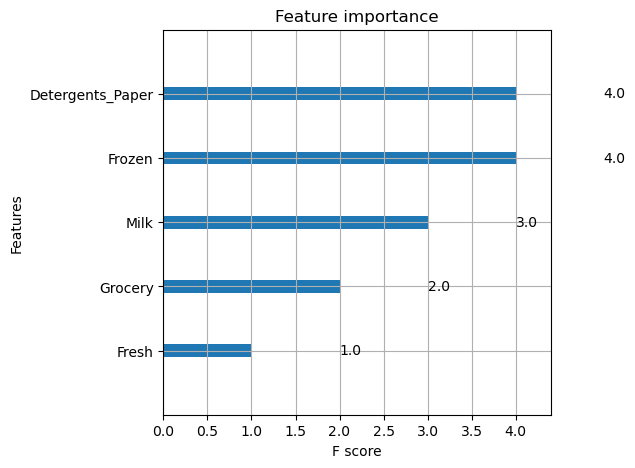

In [47]:
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()